# Transfer Learning

In [100]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [102]:
imageDirectory = "/content/gdrive/MyDrive/shape_dataset"

In [120]:
batchSize = 32
imageSize = (224, 224)
classNames = ['circle', 'line', 'square', 'triangle']

In [121]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
    imageDirectory,
    batch_size=batchSize,
    image_size=imageSize,
    class_names=classNames,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Set the split for training and validation
    subset='training'      # Choose 'training' or 'validation'
)

Found 6308 files belonging to 4 classes.
Using 5047 files for training.


In [122]:
validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
    imageDirectory,
    batch_size=batchSize,
    image_size=imageSize,
    class_names=classNames,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Set the split for training and validation
    subset='validation'      # Choose 'training' or 'validation'
)

Found 6308 files belonging to 4 classes.
Using 1261 files for validation.


In [123]:
class_names = np.array(trainDataset.class_names)
print(class_names)

['circle' 'line' 'square' 'triangle']


In [124]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = trainDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = validationDataset.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [125]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [126]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [127]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [187]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(4,activation="softmax")
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_7 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [188]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
 # Enable histogram computation for every epoch.

In [189]:
NUM_EPOCHS = 4

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


158/158 [==============================] - 158s 991ms/step - loss: 0.1773 - acc: 0.9471 - val_loss: 0.0539 - val_acc: 0.9889
Epoch 2/4
158/158 [==============================] - 163s 1s/step - loss: 0.0439 - acc: 0.9901 - val_loss: 0.0361 - val_acc: 0.9905
Epoch 3/4
158/158 [==============================] - 169s 1s/step - loss: 0.0306 - acc: 0.9925 - val_loss: 0.0297 - val_acc: 0.9905
Epoch 4/4
158/158 [==============================] - 160s 1s/step - loss: 0.0234 - acc: 0.9937 - val_loss: 0.0263 - val_acc: 0.9913


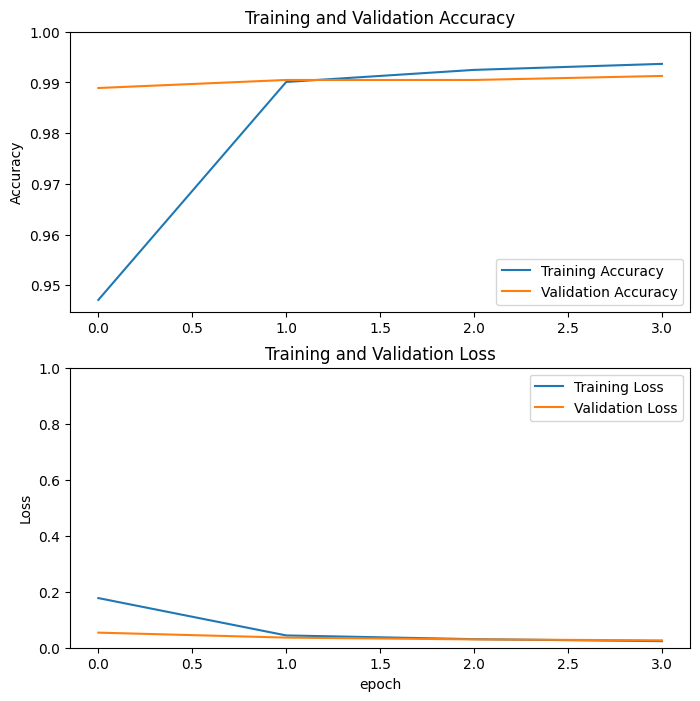

In [215]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [190]:
# Make predictions on a new image
new_image = Image.open('/content/saved10.png')
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image)
new_image_array = np.expand_dims(new_image_array, axis=0)
prediction = model.predict(new_image_array)
predicted_class = np.argmax(prediction)

1/1 [==============================] - 0s 373ms/step


In [211]:
prediction[0][1]

0.97221315

In [184]:
class_names[predicted_class]

'line'

In [197]:
model.save("/content/gdrive/MyDrive/shape_classifier_model3_transfer_learning.h5")

In [204]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_7 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________
